In [38]:
# Preamble
import numpy as np
import pandas as pd
import plotly.express as px
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

In [8]:
# Load in beer spreadsheet
main_file_path = "C:/Users/JB/Documents/Git_Repositories/Beer-Recommender/"

df = pd.read_csv(main_file_path + "Data/GABS_2023_Festival_Beers.csv").set_index("Number")

In [9]:
# Inspect data
df.head()

,Section,Brewery,Beer,Style,Description,Anticipation,Anticipation notes,Reality,Reality notes
Number,,,,,,,,,
1,1,Dad & Dave,Boba Beer,Sour,Tart Grapefruit Beliner Weisse infused with Ja...,5,"Weird, but probs boring",NaN,NaN
2,1,The Coastal Brewing Company,Homestead Blackberry and Apple Pastry Sour,Specialty,Perfect for an autumn or winter evening bringi...,6,Will have if nothing else,NaN,NaN
3,1,7th Day Brewery,Suit Up,IPA Black,Choc & raisins mingle with piney resin and cit...,7,Sounds good,NaN,NaN
4,1,Six String Brewing Co,Whiskey in the jar,Wood Aged Beer,"A barrel aged, American-Style Imperial Stout.",8,Yep,NaN,NaN
5,1,The Marsden Brewhouse,Marsden Neopolitan Porter,Stout Tropical,"Just like the ice cream, Berry - Vanilla - Cho...",10,"Weird stout, no way I'm not",NaN,NaN


In [7]:
# Calculate std dev for each section
std_df = df.groupby("Section")["Anticipation"].agg(np.var)#.reset_index()
display(std_df)

Section
1    4.673684
2    5.368421
3    4.326316
4    2.210526
5    2.852632
6    5.397368
Name: Anticipation, dtype: float64

In [10]:
# Best paddles from each section
# display(df.groupby("Section")["Anticipation"].nlargest(5, keep="all").sort_index())

# Create a column combining all text descriptor fields
df['words'] = [str(name).strip().upper() + ' '
               + str(style).strip().upper() + ' '
               + str(description).strip().upper()
               for name, style, description
               in zip(df.Beer, df.Style, df.Description)]

# TF-IDF vectorisation on description to find most unique beers?
X = TfidfVectorizer().fit_transform([re.sub(r'[\s]+', ' ', re.sub(r'[\W]', ' ', x)).upper().strip() for x in df.words])
# Average of TF-IDF?
beer_uniqueness_mean = pd.Series(np.array(np.mean(X, axis=1)).flatten())
# Cosine similarity? (and then average)
beer_uniqueness_cos = pd.Series(1 - np.mean(cosine_similarity(X), axis=1))
# Euclidean distances? (and then average)
beer_uniqueness_euc = pd.Series(np.mean(euclidean_distances(X), axis=1))

# Choose one
df['beer_uniqueness'] = beer_uniqueness_cos



In [11]:
euclidean_distances(X)

array([[0.        , 1.40062675, 1.39903301, ..., 1.34528002, 1.40116494,
        1.41421356],
       [1.40062675, 0.        , 1.40774371, ..., 1.35143153, 1.37489009,
        1.41421356],
       [1.39903301, 1.40774371, 0.        , ..., 1.4034707 , 1.39515329,
        1.41421356],
       ...,
       [1.34528002, 1.35143153, 1.4034707 , ..., 0.        , 1.24936986,
        1.22322965],
       [1.40116494, 1.37489009, 1.39515329, ..., 1.24936986, 0.        ,
        1.22221938],
       [1.41421356, 1.41421356, 1.41421356, ..., 1.22322965, 1.22221938,
        0.        ]])

In [12]:
# Interesting, I might maximise utility by getting a second paddle
# from a section before the first from another.

# Not ideal, but a while loop I guess?
all_beers = set(df.index)
paddle_index = 1
paddle_list = dict()
while len(all_beers) > 0:
    
    # Subset beer list
    temp_df = df[df.index.isin(list(all_beers))]
    
    # Find the section with the best paddle
    sec = temp_df.sort_values("beer_uniqueness", ascending=False) \
            .groupby("Section")["Anticipation"].nlargest(5).reset_index() \
            .groupby("Section") \
            .agg("sum") \
            .join(pd.DataFrame(std_df).rename(columns={"Anticipation":"std"}), on="Section") \
            .sort_values(["Anticipation", "std"], ascending=False) \
            .index[0]
    
    # Get that paddle
    paddle = list(temp_df[temp_df.Section==sec].sort_values(["Anticipation", "beer_uniqueness"], ascending=[False, False]).head(5).reset_index().Number)
    
    # Store that paddle
    paddle_list[str(paddle_index)] = (f'Section {sec}', paddle)
    
    # Increment paddle index
    paddle_index += 1
    
    # Update remaining beers
    all_beers = all_beers - set(paddle)

# Display results
for key, value in paddle_list.items():
    print(f'{key}: ', value)

1:  ('Section 2', [40, 34, 39, 29, 22])
2:  ('Section 3', [57, 49, 52, 42, 41])
3:  ('Section 4', [76, 80, 69, 74, 73])
4:  ('Section 5', [88, 91, 96, 98, 83])
5:  ('Section 6', [109, 106, 111, 101, 105])
6:  ('Section 3', [47, 59, 51, 43, 56])
7:  ('Section 1', [5, 19, 15, 7, 14])
8:  ('Section 5', [95, 86, 85, 84, 82])
9:  ('Section 4', [70, 67, 65, 63, 75])
10:  ('Section 6', [107, 108, 110, 118, 112])
11:  ('Section 2', [23, 28, 33, 37, 30])
12:  ('Section 4', [68, 64, 61, 62, 77])
13:  ('Section 1', [4, 17, 8, 11, 12])
14:  ('Section 5', [93, 90, 97, 99, 94])
15:  ('Section 3', [44, 55, 46, 53, 50])
16:  ('Section 6', [103, 104, 116, 102, 113])
17:  ('Section 2', [27, 26, 24, 31, 35])
18:  ('Section 1', [3, 18, 6, 16, 10])
19:  ('Section 4', [79, 66, 72, 78, 71])
20:  ('Section 5', [92, 87, 81, 100, 89])
21:  ('Section 3', [54, 48, 60, 58, 45])
22:  ('Section 1', [20, 2, 1, 9, 13])
23:  ('Section 2', [25, 21, 38, 32, 36])
24:  ('Section 6', [114, 117, 120, 115, 119])


In [168]:
# Display Results
rank = []
section = []
beer1 = []
beer2 = []
beer3 = []
beer4 = []
beer5 = []
for key, value in paddle_list.items():
    rank.append(key)
    section.append(value[0])
    beer1.append(value[1][0])
    beer2.append(value[1][1])
    beer3.append(value[1][2])
    beer4.append(value[1][3])
    beer5.append(value[1][4])
    
god_tier_paddle_tiers_df = pd.DataFrame({"Rank":rank,
                                         "Section":section,
                                         "Beer 1":beer1,
                                         "Beer 2":beer2,
                                         "Beer 3":beer3,
                                         "Beer 4":beer4,
                                         "Beer 5":beer5})

display(god_tier_paddle_tiers_df)

,Rank,Section,Beer 1,Beer 2,Beer 3,Beer 4,Beer 5
0,1,Section 2,40,34,39,29,22
1,2,Section 3,57,49,52,42,41
2,3,Section 4,76,80,69,74,73
3,4,Section 5,88,91,96,98,83
4,5,Section 6,109,106,111,101,105
5,6,Section 3,47,59,51,43,56
6,7,Section 1,5,19,15,7,14
7,8,Section 5,95,86,85,84,82
8,9,Section 4,70,67,65,63,75
9,10,Section 6,107,108,110,118,112


In [13]:
fig = px.box(df,
             x="Section",
             y="Anticipation")
fig.show()

In [14]:
df.groupby("Section")["Anticipation"].agg(np.std).reset_index()

,Section,Anticipation
0,1,2.161871
1,2,2.316985
2,3,2.079980
3,4,1.486784
4,5,1.688974
5,6,2.323224


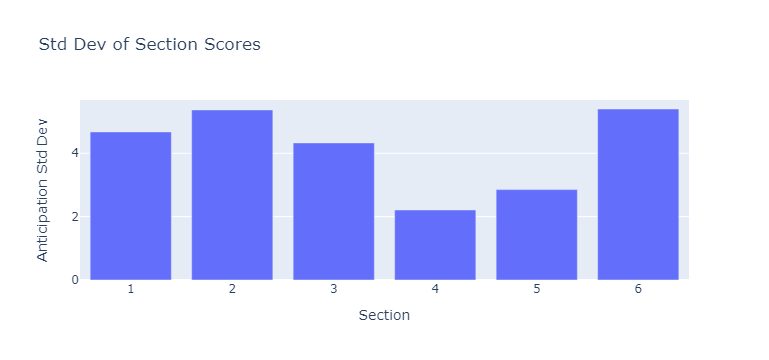

In [45]:
fig = px.bar(std_df.reset_index(),
             x="Section", y="Anticipation",
             labels={"Anticipation":"Anticipation Std Dev"},
             title="Std Dev of Section Scores")
fig.show()

In [15]:
fig = px.bar(df[df.index!=45].groupby("Section")["Anticipation"].agg(np.var).reset_index(),
             x="Section", y="Anticipation",
             labels={"Anticipation":"Anticipation Std Dev"},
             title="Std Dev of Section Scores (one bad beer removed)")
fig.show()

In [20]:
# Plot some clusters maybe?
pca_arr_all = PCA(n_components=2).fit_transform(np.asarray(X.todense()))
print(pca_arr_all.shape)


pca_df = pd.DataFrame(pca_arr_all).reset_index(drop=True).set_index(df.index)
pca_df['Section'] = df.Section
pca_df['Number'] = df.index
pca_df['Beer'] = df.Beer
pca_df['Brewery'] = df.Brewery
pca_df['Style'] = df.Style
pca_df['Anticipation'] = df.Anticipation

fig = px.scatter(pca_df,
                 x=0,
                 y=1,
                 color="Style",
                 hover_data=["Beer", "Section", "Number"]
                )
fig.show()

(120, 2)


In [21]:
# t-SNE?
pca_arr = PCA(n_components=50).fit_transform(np.asarray(X.todense()))
print(pca_arr.shape)
tsne_arr = TSNE().fit_transform(pca_arr)
print(tsne_arr.shape)

tsne_df = pd.DataFrame(tsne_arr).reset_index(drop=True).set_index(df.index)
tsne_df['Section'] = df.Section
tsne_df['Number'] = df.index
tsne_df['Beer'] = df.Beer
tsne_df['Brewery'] = df.Brewery
tsne_df['Style'] = df.Style
tsne_df['Anticipation'] = df.Anticipation


(120, 50)
(120, 2)


In [22]:
display(tsne_df)

,0,1,Section,Number,Beer,Brewery,Style,Anticipation
Number,,,,,,,,
1,-6.479331,-4.309200,1,1,Boba Beer,Dad & Dave,Sour,5
2,-6.194849,-0.036571,1,2,Homestead Blackberry and Apple Pastry Sour,The Coastal Brewing Company,Specialty,6
3,5.666737,4.686922,1,3,Suit Up,7th Day Brewery,IPA Black,7
4,3.303320,-2.941264,1,4,Whiskey in the jar,Six String Brewing Co,Wood Aged Beer,8
5,1.870356,-7.959568,1,5,Marsden Neopolitan Porter,The Marsden Brewhouse,Stout Tropical,10
...,...,...,...,...,...,...,...,...
116,3.358276,-0.855311,6,116,Barrel Aged Seltzerita,Felons Brewing Co,Seltzer,7
117,-6.692358,4.713624,6,117,Apple and Black Currant Cider,Cedar Creek Cider,Cider,4
118,-3.126622,0.777409,6,118,Sour Pineapple Sour,Spreyton Cider Co,Cider,8


In [23]:
fig = px.scatter(tsne_df,
                 x=0,
                 y=1,
                 color="Style",
                 hover_data=["Beer", "Section", "Number"]
                )
fig.show()

In [222]:
tsne_df.to_csv(main_file_path + "Data/GABS_embedding.csv")

In [36]:
# Create distance matrix

column_name_dict = {}
i = 0
for j in df.index:
    column_name_dict[i] = j
    i += 1

distance_df = pd.DataFrame(normalize(euclidean_distances(X))).rename(columns=column_name_dict).reset_index(drop=True).set_index(df.index)

distance_df['Section'] = df.Section
distance_df['Number'] = df.index
distance_df['Beer'] = df.Beer
distance_df['Brewery'] = df.Brewery
distance_df['Style'] = df.Style
distance_df['Anticipation'] = df.Anticipation

distance_df.head()

,1,2,3,4,5,6,7,8,9,10,...,117,118,119,120,Section,Number,Beer,Brewery,Style,Anticipation
Number,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.092180,0.092075,0.090823,0.093074,0.090693,0.093074,0.093074,0.093074,0.092131,...,0.093074,0.088538,0.092216,0.093074,1,1,Boba Beer,Dad & Dave,Sour,5
2,0.092026,0.000000,0.092493,0.092919,0.092919,0.091068,0.092497,0.090799,0.092919,0.092919,...,0.089530,0.088794,0.090335,0.092919,1,2,Homestead Blackberry and Apple Pastry Sour,The Coastal Brewing Company,Specialty,6
3,0.092244,0.092819,0.000000,0.093245,0.093245,0.093245,0.092735,0.090391,0.093245,0.092355,...,0.089564,0.092537,0.091989,0.093245,1,3,Suit Up,7th Day Brewery,IPA Black,7
4,0.090990,0.093245,0.093245,0.000000,0.090094,0.093245,0.093245,0.085901,0.091853,0.093245,...,0.093245,0.093245,0.093245,0.093245,1,4,Whiskey in the jar,Six String Brewing Co,Wood Aged Beer,8
5,0.093532,0.093532,0.093532,0.090371,0.000000,0.093532,0.093532,0.091766,0.092032,0.093532,...,0.093532,0.093532,0.093532,0.093532,1,5,Marsden Neopolitan Porter,The Marsden Brewhouse,Stout Tropical,10


In [37]:
distance_df.to_csv(main_file_path + "Data/GABS_distances.csv")

In [50]:
nn = NearestNeighbors(n_neighbors=10, metric='precomputed')
nn.fit(euclidean_distances(X))

distances, indexes = nn.kneighbors()


In [56]:
print(len(list(indexes[0])))

print(list(range(1, 10)))

10
[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [59]:
sim_df = pd.DataFrame(columns=['Beer', 'Sim_Rank', 'Sim_Beer'])

for beer in df.index:
    sim_list = list(indexes[beer-1]+1)
    beer_list = [beer for _ in sim_list]
    sim_rank = list(range(1, len(sim_list)+1))
    temp_df = pd.DataFrame({'Beer':beer_list, 'Sim_Rank':sim_rank, 'Sim_Beer':sim_list})
    sim_df = pd.concat([sim_df, temp_df])

display(sim_df)
sim_df.to_csv(main_file_path + "Data/GABS_sim_neighbours.csv")



,Beer,Sim_Rank,Sim_Beer
0,1,1,58
1,1,2,102
2,1,3,67
3,1,4,44
4,1,5,109
...,...,...,...
5,120,6,91
6,120,7,114
7,120,8,32
8,120,9,116
